In [1]:
!pip3 show tensorflow-federated

Name: tensorflow-federated
Version: 0.19.0
Summary: TensorFlow Federated is an open-source federated learning framework.
Home-page: http://tensorflow.org/federated
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/gonzaq/venv/lib/python3.6/site-packages
Requires: attrs, dm-tree, tqdm, jax, absl-py, jaxlib, tensorflow-model-optimization, portpicker, retrying, tensorflow, cachetools, tensorflow-privacy, semantic-version, grpcio, numpy
Required-by: 


In [10]:
%load_ext tensorboard

In [6]:
import nest_asyncio
nest_asyncio.apply()

In [11]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

# Data exploration

In [12]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [47]:
print('Number of clients: {} '.format(len(emnist_train.client_ids)))

Number of clients: 3383 


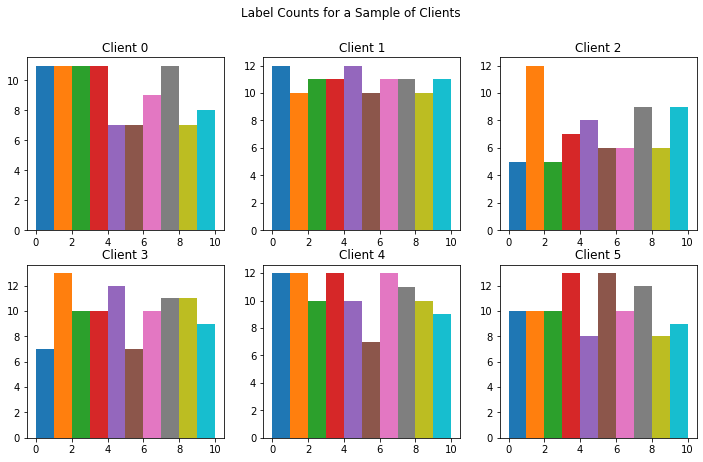

In [44]:
import matplotlib.pyplot as plt

# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
    client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['label'].numpy()
        plot_data[label].append(label)
    plt.subplot(2, 3, i+1)
    plt.title('Client {}'.format(i))
    for j in range(10):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

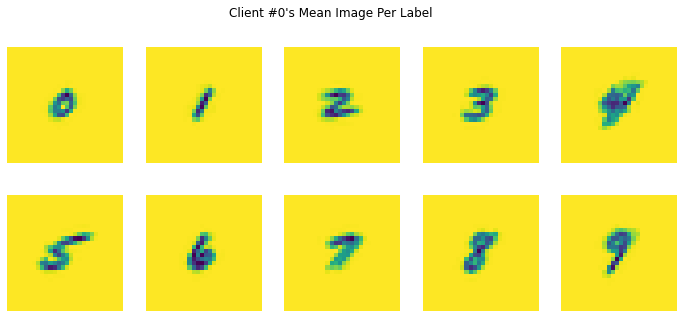

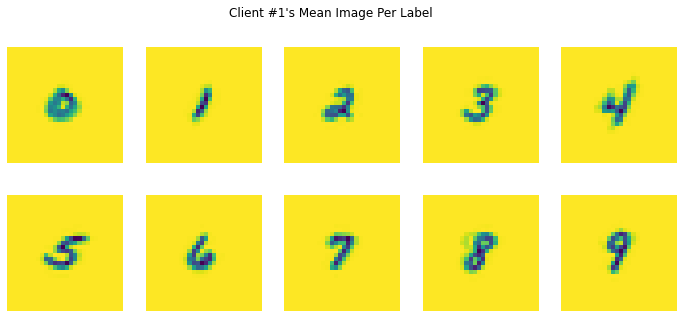

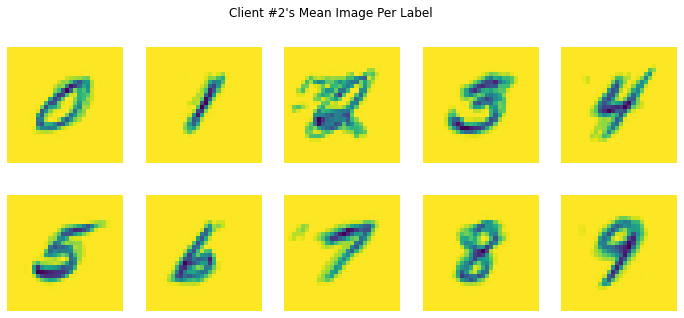

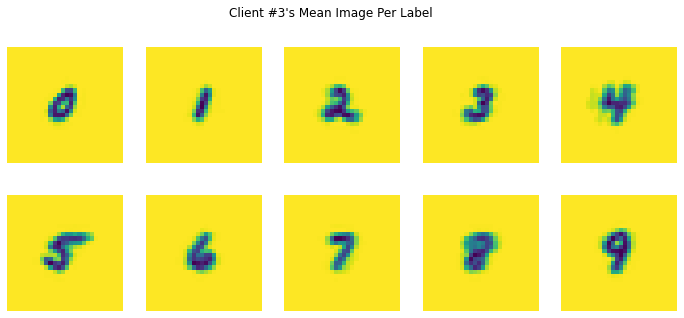

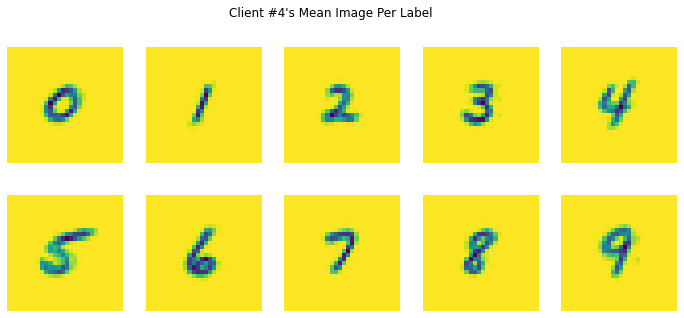

In [32]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j+1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

# Data preprocessing

In [39]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
    
    # 1) Flatten the 28x28 images into 784-element arrays
    # 2) Shuffle the individual examples
    # 3) Organize them into batches
    # 4) Rename the features from pixels and label to x and y for use with Keras
    # 5) Repeat over the data set to run several epochs

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [40]:
def make_federated_data(client_data, client_ids):
    # Constructs a list of datasets, each dataset corresponding to a user
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Create model with Keras

In [35]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])
preprocessed_example_dataset = preprocess(example_dataset)

In [36]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(784,)),
      tf.keras.layers.Dense(10, kernel_initializer='zeros'),
      tf.keras.layers.Softmax(),
    ])

In [37]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Training with FedAvg

In [54]:
# Implementation of the federated computations, the base of this implementation of FL
# In this case, we use the FedAvg algorithm
iterative_process_fed_avg = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

evaluation = tff.learning.build_federated_evaluation(model_fn)

In [51]:
# For visualizing the training in tensorboard, we instantiate the summary writer
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

In [52]:
# Start tensorboard
!ls {logdir}
%tensorboard --logdir {logdir} --port=0

events.out.tfevents.1628089898.gonzaq-Satellite-C55-C.15279.22971.v2


In [61]:
import random

NUM_ROUNDS = 2000

# Construct the original server state
state = iterative_process_fed_avg.initialize()
with summary_writer.as_default():
    for round_num in range(2, NUM_ROUNDS):

        # Randomly pick NUM_CLIENTS
        sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS)

        # take the datasets of each client
        federated_train_data = make_federated_data(emnist_train, sample_clients)
        federated_test_data = make_federated_data(emnist_test, sample_clients)

        # FL iteration
        state, metrics = iterative_process_fed_avg.next(state, federated_train_data)
        
        metrics['test'] = evaluation(state.model, federated_train_data)

        print('round {:2d}, metrics={}'.format(round_num, metrics))
        
        for name, value in metrics['train'].items():
            tf.summary.scalar('train_'+name, value, step=round_num)
            
        for name, value in metrics['test'].items():
            tf.summary.scalar('test_'+name, value, step=round_num)


round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.11607476), ('loss', 3.0975025)])), ('stat', OrderedDict([('num_examples', 5350)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.093457945), ('loss', 2.630277)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.13695653), ('loss', 2.969786)])), ('stat', OrderedDict([('num_examples', 5060)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.17984189), ('loss', 2.3059158)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.14349951), ('loss', 2.9204578)])), ('stat', OrderedDict([('num_examples', 5115)])), ('test', OrderedDict([('s

round 26, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.51), ('loss', 1.4813749)])), ('stat', OrderedDict([('num_examples', 5000)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.634), ('loss', 1.3232739)]))])
round 27, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.5530275), ('loss', 1.4158878)])), ('stat', OrderedDict([('num_examples', 5450)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.70917434), ('loss', 1.1588637)]))])
round 28, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.615056), ('loss', 1.256537)])), ('stat', OrderedDict([('num_examples', 4915)])), ('test', OrderedDict([('sparse_categori

round 50, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7172345), ('loss', 0.96308094)])), ('stat', OrderedDict([('num_examples', 4990)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.757515), ('loss', 0.8621702)]))])
round 51, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.71591353), ('loss', 0.9595139)])), ('stat', OrderedDict([('num_examples', 5090)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7750491), ('loss', 0.8520333)]))])
round 52, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7543893), ('loss', 0.8989186)])), ('stat', OrderedDict([('num_examples', 5240)])), ('test', OrderedDict([('spar

round 74, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.75014216), ('loss', 0.8549398)])), ('stat', OrderedDict([('num_examples', 5275)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7601896), ('loss', 0.8074326)]))])
round 75, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8756547), ('loss', 0.5206691)])), ('stat', OrderedDict([('num_examples', 5155)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.86614937), ('loss', 0.5429509)]))])
round 76, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7476323), ('loss', 0.8407829)])), ('stat', OrderedDict([('num_examples', 5385)])), ('test', OrderedDict([('spa

round 98, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.79602647), ('loss', 0.72857255)])), ('stat', OrderedDict([('num_examples', 5285)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.78807944), ('loss', 0.7212234)]))])
round 99, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8252049), ('loss', 0.65980446)])), ('stat', OrderedDict([('num_examples', 4880)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8360656), ('loss', 0.6323161)]))])
round 100, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.80292684), ('loss', 0.73858994)])), ('stat', OrderedDict([('num_examples', 5125)])), ('test', OrderedDict([

round 122, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7748319), ('loss', 0.76414615)])), ('stat', OrderedDict([('num_examples', 5205)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7732949), ('loss', 0.7435143)]))])
round 123, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8256461), ('loss', 0.6492621)])), ('stat', OrderedDict([('num_examples', 5030)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.80318093), ('loss', 0.7071382)]))])
round 124, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8217742), ('loss', 0.63585114)])), ('stat', OrderedDict([('num_examples', 4960)])), ('test', OrderedDict([(

round 146, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.83666027), ('loss', 0.60577875)])), ('stat', OrderedDict([('num_examples', 5210)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7975048), ('loss', 0.66403484)]))])
round 147, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.82382447), ('loss', 0.63107246)])), ('stat', OrderedDict([('num_examples', 4785)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7742947), ('loss', 0.7018858)]))])
round 148, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8588), ('loss', 0.5408021)])), ('stat', OrderedDict([('num_examples', 5000)])), ('test', OrderedDict([('

round 169, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.85046554), ('loss', 0.5179239)])), ('stat', OrderedDict([('num_examples', 5370)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84264433), ('loss', 0.55405456)]))])
round 170, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8352941), ('loss', 0.58481187)])), ('stat', OrderedDict([('num_examples', 5440)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8180147), ('loss', 0.61224645)]))])
round 171, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.78842), ('loss', 0.7142351)])), ('stat', OrderedDict([('num_examples', 5095)])), ('test', OrderedDict([(

round 192, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8275154), ('loss', 0.6208181)])), ('stat', OrderedDict([('num_examples', 4870)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8059548), ('loss', 0.69249856)]))])
round 193, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.89524716), ('loss', 0.41993177)])), ('stat', OrderedDict([('num_examples', 5260)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.89353615), ('loss', 0.4272149)]))])
round 194, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8454448), ('loss', 0.5089004)])), ('stat', OrderedDict([('num_examples', 4665)])), ('test', OrderedDict([

round 215, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8692446), ('loss', 0.447993)])), ('stat', OrderedDict([('num_examples', 5560)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84802157), ('loss', 0.4926974)]))])
round 216, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8974695), ('loss', 0.43929556)])), ('stat', OrderedDict([('num_examples', 5335)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.86223054), ('loss', 0.49070376)]))])
round 217, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8790614), ('loss', 0.4350609)])), ('stat', OrderedDict([('num_examples', 5540)])), ('test', OrderedDict([(

round 238, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.83870316), ('loss', 0.5482402)])), ('stat', OrderedDict([('num_examples', 4935)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8125633), ('loss', 0.6194033)]))])
round 239, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7899902), ('loss', 0.668858)])), ('stat', OrderedDict([('num_examples', 5095)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7576055), ('loss', 0.7954287)]))])
round 240, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8463321), ('loss', 0.5112278)])), ('stat', OrderedDict([('num_examples', 5180)])), ('test', OrderedDict([('sp

round 261, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8678862), ('loss', 0.48179764)])), ('stat', OrderedDict([('num_examples', 4920)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8292683), ('loss', 0.576175)]))])
round 262, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8626582), ('loss', 0.48527163)])), ('stat', OrderedDict([('num_examples', 4740)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.78902954), ('loss', 0.70248395)]))])
round 263, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.7529297), ('loss', 0.76838696)])), ('stat', OrderedDict([('num_examples', 5120)])), ('test', OrderedDict([

round 285, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9110492), ('loss', 0.33532262)])), ('stat', OrderedDict([('num_examples', 5385)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8950789), ('loss', 0.38632885)]))])
round 286, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8528908), ('loss', 0.51690674)])), ('stat', OrderedDict([('num_examples', 4670)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8308351), ('loss', 0.59015745)]))])
round 287, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8897248), ('loss', 0.39586064)])), ('stat', OrderedDict([('num_examples', 5450)])), ('test', OrderedDict(

round 308, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8608779), ('loss', 0.5136343)])), ('stat', OrderedDict([('num_examples', 5240)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84828246), ('loss', 0.55538124)]))])
round 309, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.86539924), ('loss', 0.48733857)])), ('stat', OrderedDict([('num_examples', 5260)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8231939), ('loss', 0.6071784)]))])
round 310, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8263715), ('loss', 0.561651)])), ('stat', OrderedDict([('num_examples', 5195)])), ('test', OrderedDict([(

round 331, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8874494), ('loss', 0.42944157)])), ('stat', OrderedDict([('num_examples', 4940)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8380567), ('loss', 0.5298755)]))])
round 332, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8048497), ('loss', 0.6569185)])), ('stat', OrderedDict([('num_examples', 5155)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.76721627), ('loss', 0.79644394)]))])
round 333, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88825995), ('loss', 0.42133838)])), ('stat', OrderedDict([('num_examples', 4770)])), ('test', OrderedDict(

round 354, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.84601414), ('loss', 0.5016128)])), ('stat', OrderedDict([('num_examples', 4955)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.81432897), ('loss', 0.6092131)]))])
round 355, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.84271455), ('loss', 0.52283245)])), ('stat', OrderedDict([('num_examples', 5010)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.81037927), ('loss', 0.62270355)]))])
round 356, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8742911), ('loss', 0.4214584)])), ('stat', OrderedDict([('num_examples', 5290)])), ('test', OrderedDict

round 377, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88698167), ('loss', 0.40958497)])), ('stat', OrderedDict([('num_examples', 5185)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84860176), ('loss', 0.49116278)]))])
round 378, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.87796277), ('loss', 0.40462065)])), ('stat', OrderedDict([('num_examples', 5105)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8511264), ('loss', 0.46314657)]))])
round 379, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.85270405), ('loss', 0.5328911)])), ('stat', OrderedDict([('num_examples', 5085)])), ('test', OrderedDi

round 400, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8929875), ('loss', 0.3987399)])), ('stat', OrderedDict([('num_examples', 5205)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8635927), ('loss', 0.4605837)]))])
round 401, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9006012), ('loss', 0.38793728)])), ('stat', OrderedDict([('num_examples', 4990)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8667335), ('loss', 0.46032807)]))])
round 402, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8580259), ('loss', 0.46574837)])), ('stat', OrderedDict([('num_examples', 5015)])), ('test', OrderedDict([(

round 423, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8791016), ('loss', 0.43097836)])), ('stat', OrderedDict([('num_examples', 5120)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.83691406), ('loss', 0.5284642)]))])
round 424, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8718563), ('loss', 0.46025127)])), ('stat', OrderedDict([('num_examples', 5010)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84131736), ('loss', 0.543)]))])
round 425, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8921028), ('loss', 0.36117324)])), ('stat', OrderedDict([('num_examples', 5255)])), ('test', OrderedDict([('s

round 446, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8449902), ('loss', 0.49702138)])), ('stat', OrderedDict([('num_examples', 5090)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.7848723), ('loss', 0.6632925)]))])
round 447, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8833333), ('loss', 0.41852242)])), ('stat', OrderedDict([('num_examples', 5040)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8492063), ('loss', 0.5225942)]))])
round 448, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8887526), ('loss', 0.41695285)])), ('stat', OrderedDict([('num_examples', 4890)])), ('test', OrderedDict([(

round 469, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.89162654), ('loss', 0.38475582)])), ('stat', OrderedDict([('num_examples', 5195)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8691049), ('loss', 0.4555071)]))])
round 470, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8709091), ('loss', 0.4493473)])), ('stat', OrderedDict([('num_examples', 4950)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84141415), ('loss', 0.5153767)]))])
round 471, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88232934), ('loss', 0.42276523)])), ('stat', OrderedDict([('num_examples', 4980)])), ('test', OrderedDict(

round 492, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88161993), ('loss', 0.41377106)])), ('stat', OrderedDict([('num_examples', 4815)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8764278), ('loss', 0.44869426)]))])
round 493, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8686829), ('loss', 0.42651615)])), ('stat', OrderedDict([('num_examples', 5125)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8321951), ('loss', 0.49999887)]))])
round 494, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9003208), ('loss', 0.35364708)])), ('stat', OrderedDict([('num_examples', 4675)])), ('test', OrderedDict

round 515, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9007843), ('loss', 0.37862548)])), ('stat', OrderedDict([('num_examples', 5100)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.84705883), ('loss', 0.4899374)]))])
round 516, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9002997), ('loss', 0.36310455)])), ('stat', OrderedDict([('num_examples', 5005)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8761239), ('loss', 0.4122739)]))])
round 517, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88967496), ('loss', 0.3462512)])), ('stat', OrderedDict([('num_examples', 5230)])), ('test', OrderedDict([

round 539, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.95413226), ('loss', 0.21570422)])), ('stat', OrderedDict([('num_examples', 4840)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.9431818), ('loss', 0.25101373)]))])
round 540, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8650728), ('loss', 0.4817462)])), ('stat', OrderedDict([('num_examples', 4810)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8492724), ('loss', 0.5421057)]))])
round 541, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.78736424), ('loss', 0.67783654)])), ('stat', OrderedDict([('num_examples', 5065)])), ('test', OrderedDict(

round 562, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8950951), ('loss', 0.38634405)])), ('stat', OrderedDict([('num_examples', 4995)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8628629), ('loss', 0.46134382)]))])
round 563, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.89106965), ('loss', 0.39042076)])), ('stat', OrderedDict([('num_examples', 5095)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.85868496), ('loss', 0.5003506)]))])
round 564, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.87023807), ('loss', 0.4501833)])), ('stat', OrderedDict([('num_examples', 5040)])), ('test', OrderedDict

round 585, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9026804), ('loss', 0.35432026)])), ('stat', OrderedDict([('num_examples', 4850)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.87628865), ('loss', 0.42278138)]))])
round 586, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.91643566), ('loss', 0.31651345)])), ('stat', OrderedDict([('num_examples', 5050)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.9019802), ('loss', 0.37690997)]))])
round 587, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.8959624), ('loss', 0.3703531)])), ('stat', OrderedDict([('num_examples', 5325)])), ('test', OrderedDict

round 608, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.89300096), ('loss', 0.3818679)])), ('stat', OrderedDict([('num_examples', 5215)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8676894), ('loss', 0.5008582)]))])
round 609, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.91373307), ('loss', 0.31322506)])), ('stat', OrderedDict([('num_examples', 5170)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.8868472), ('loss', 0.34894437)]))])
round 610, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.86498547), ('loss', 0.484966)])), ('stat', OrderedDict([('num_examples', 5155)])), ('test', OrderedDict([

round 631, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.9198869), ('loss', 0.29540366)])), ('stat', OrderedDict([('num_examples', 5305)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.89066917), ('loss', 0.37442002)]))])
round 632, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88741845), ('loss', 0.3851343)])), ('stat', OrderedDict([('num_examples', 5365)])), ('test', OrderedDict([('sparse_categorical_accuracy', 0.86859274), ('loss', 0.44907686)]))])
round 633, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('sparse_categorical_accuracy', 0.88121355), ('loss', 0.4053994)])), ('stat', OrderedDict([('num_examples', 4285)])), ('test', OrderedDic

KeyboardInterrupt: 